# Images From Galaxy Particle distributions

Synthesizer can create various different types of images and maps from particle data.

In the example below we demonstrate this for a galaxy stellar distribution taken from a CAMELS simulation galaxy.

In [1]:
import time

import matplotlib.colors as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from scipy import signal
from unyt import Hz, erg, kpc, s, angstrom

from synthesizer.emission_models import IncidentEmission
from synthesizer.filters import FilterCollection as Filters
from synthesizer.grid import Grid
from synthesizer.kernel_functions import Kernel
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG

# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600) * angstrom)

# Create galaxy object
gal = load_CAMELS_IllustrisTNG(
    "../../../tests/data/",
    snap_name="camels_snap.hdf5",
    group_name="camels_subhalo.hdf5",
    physical=True,
)[0]

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


### Getting the photometry

To make an image we need to generate spectra for each individual star particle. To do this we use the galaxy's in built `get_spectra` method and pass a `per_particle` model. This will generate a spectrum for each particle in the galaxy.

We can then calculate the photometry on these spectra by defining a filter collection, and calculating the luminosities.


In [2]:
# Calculate the stellar rest frame SEDs for all particles in erg / s / Hz
model = IncidentEmission(grid, per_particle=True)
sed = gal.stars.get_spectra(model)

# Calculate the observed SED in nJy
sed.get_fnu(cosmo, gal.redshift, igm=None)

filter_codes = [
    "JWST/NIRCam.F090W",
    "JWST/NIRCam.F150W",
    "JWST/NIRCam.F200W",
]

filters = Filters(filter_codes, new_lam=grid.lam)

gal.stars.particle_spectra["incident"].get_photo_lnu(filters)

## Imaging

The last step before we can make any images is to define the resolution of our images and the FOV (or width) of the images. These must have units associated to them to enable the code to internally transform all quantites to a consistent unit system.

In [3]:
# Define the width of the image
width = 30 * kpc

# Define image resolution (here we arbitrarily set it to 100
# pixels along an axis)
resolution = width / 200

print(
    "Image width is %.2f kpc with %.2f kpc resolution"
    % (width.value, resolution.value)
)

Image width is 30.00 kpc with 0.15 kpc resolution


Now we have everything we need to make images. Although it is possible to work with the low level `ImageCollection` and `Image` methods, here we use the interface on a `Galaxy`. There are two of these helper methods, `get_imgs_luminosity` for luminosity images, and `get_imgs_flux` for flux images. We will focus on the former here.

The image helper methods both take the image properties we previously defined, and a spectra type. These types can be any spectra for which you have calculated photometry, e.g. `"incident"`, `"intrinsic"`, or `"attenuated"`, for either stars (`stellar_photometry`) or black holes (`blackhole_photometry`). If both a stellar and black hole photometry type are passed then an image is made for each component before they are combined and returned.

Images can either be simple 2D histograms, or the particles can be smoothed over their kernels. What type of image is made is controlled by the `img_type` argument. Below we demonstrate both approaches. However, for the latter we also need to define a kernel, which we have already imported from the `kernel_functions` module.

In [4]:
# Get the SPH kernel
sph_kernel = Kernel()
kernel_data = sph_kernel.get_kernel()

# Get the image
hist_imgs = gal.get_images_luminosity(
    resolution,
    fov=width,
    img_type="hist",
    stellar_photometry="incident",
    blackhole_photometry=None,
)

# Get the image
smooth_imgs = gal.get_images_luminosity(
    resolution,
    fov=width,
    img_type="smoothed",
    stellar_photometry="incident",
    blackhole_photometry=None,
    kernel=kernel_data,
    kernel_threshold=1,
)

When making images in multiple bands, the image arrays themselves are stored on the returned `ImageCollection` in a dictionary called `imgs`, of the form `{filter_code: Image}`.
Here, an `Image` is a container including the image array itself (`arr`), unit information (`units`) and the `resolution` and `fov` of the image. An `Image` object also includes a number of different methods for manipulating and visualising individual images. 

Below we will extract this dictionary and plot each of the images we have made.

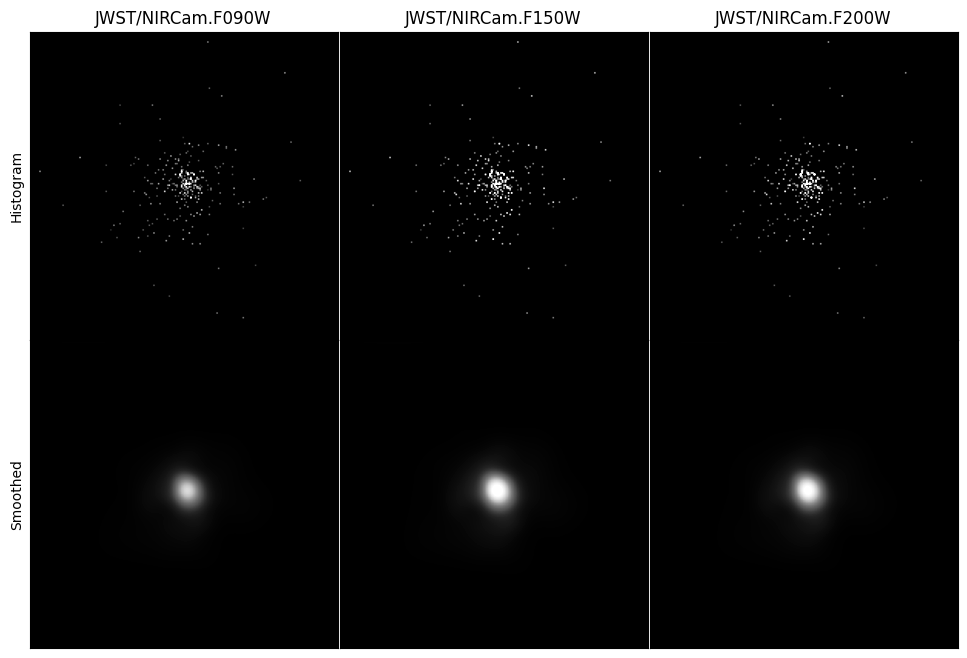

In [5]:
# Lets set up a simple normalisation across all images
vmax = 0
for img in hist_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up
hist_norm = cm.Normalize(vmin=0, vmax=vmax)
vmax = 0
for img in smooth_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up
smooth_norm = cm.Normalize(vmin=0, vmax=vmax)


# Set up plot
fig = plt.figure(figsize=(4 * len(filters), 4 * 2))
gs = gridspec.GridSpec(2, len(filters), hspace=0.0, wspace=0.0)

# Create top row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[0, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(hist_imgs[fcode].arr, norm=hist_norm, cmap="Greys_r")
    ax.set_title(fcode)
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
        bottom=False,
        top=False,
        labelbottom=False,
        labeltop=False,
    )

# Set y axis label on left most plot
axes[0].set_ylabel("Histogram")

# Create bottom row
axes = []
for i in range(len(filters)):
    axes.append(fig.add_subplot(gs[1, i]))

# Loop over images plotting them
for ax, fcode in zip(axes, filter_codes):
    ax.imshow(smooth_imgs[fcode].arr, norm=smooth_norm, cmap="Greys_r")
    ax.tick_params(
        axis="both",
        which="both",
        left=False,
        right=False,
        labelleft=False,
        labelright=False,
        bottom=False,
        top=False,
        labelbottom=False,
        labeltop=False,
    )

# Set y axis label on left most plot
axes[0].set_ylabel("Smoothed")

# Plot the image
plt.show()
plt.close(fig)

## Applying a Point Spread Function (PSF)

To properly model observations from a particular instrument we must take into account the point spread function (PSF). 

To apply a PSF we can either use `Image.apply_psf` on individual `Image` objects, or apply a dictionary of PSFs, of the form `{filter_code: psf_array}`, to each image in an `ImageCollection` with the `apply_psfs` method. Here we will just create a fake gaussian PSF for all filters, but PSFs can be sourced however the user wishes (for Webb we recommend the _webbpsf_ package), as long as a simple numpy array is passed within the psf dictionary for each filter.

To get the most accurate result from the PSF convolution it is recommended to do the convolution on a super-sampled image (i.e. much higher resolution than the PSF). Although-here we just supersample the images we have already made, it is recommended to first make the images at the super-sampled resolution, and then subsequently downsample after the fact. 

In [6]:
# Create a fake PSF for each filter
psf = np.outer(
    signal.windows.gaussian(100, 3), signal.windows.gaussian(100, 3)
)
psfs = {f: psf for f in filters.filter_codes}

# Supersample the image
smooth_imgs.supersample(2)

# Apply the PSFs
psf_imgs = smooth_imgs.apply_psfs(psfs)

# And downsample back to the native resolution
smooth_imgs.downsample(0.5)
psf_imgs.downsample(0.5)

`apply_psfs` returns a new `ImageCollection` containing the newly convolved `Image` objects. We can now use the plotting helper function to plot these images, with some normalisation.

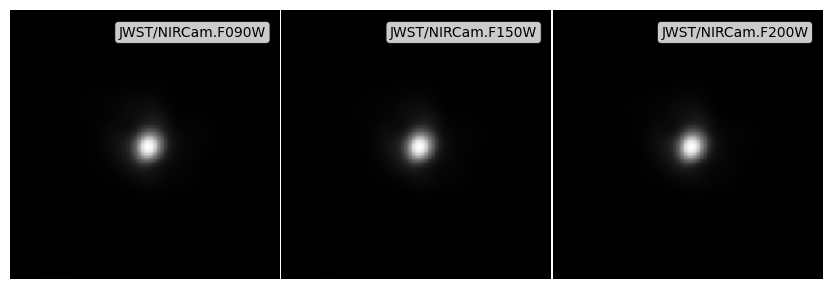

In [7]:
# Lets set up a simple normalisation across all images
vmax = 0
for img in psf_imgs.values():
    up = np.percentile(img.arr, 99.9)
    if up > vmax:
        vmax = up

# Get the plot
fig, ax = psf_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

## Applying noise

The final ingredient for a fully forward modelled synthetic image is a noise field. We include 4 different to approaches to include noise: 
- `apply_noise_array`: Add an existing noise field / array.
- `apply_noise_from_std`: Derive a noise distribution, centered on 0, given a user specified standard deviation, and then generate and add a noise array. 
- `apply_noise_from_snr` (aperture): Derive a noise distribution from a Signal-to-Noise Ratio (SNR), defined in an aperture with size `aperture_radius` and a specified `depth`. This will derive the standard deviation of the noise distribution assuming $SNR= S / \sigma$ for an aperture, before deriving the per pixel noise, computing the noise array and adding it.
- `apply_noise_from_snr` (point source): Derive a noise distribution from a SNR and depth. This will derive the standard deviation of the noise distribution assuming $SNR= S / \sigma$ for a pixel before computing the noise array and adding it. This behaviour can be achieved by omitting `aperture_radius` in the call to `apply_noise_from_snr`
    
As with applying a PSF, these methods have singular versions (as listed above) which can be used on an individual `Image`, and pluralised versions which can be used on an `ImageCollection`, and take dictionaries for each of the arguments. 

If an image has units then the passed `noise_arr` or `noise_std` must also have units.

Applying noise with any of the methods described above will return a new `ImageCollection` / `Image` containing the noisy image. In addition to the noisy image (stored under `Image.arr`) the new `Image` (or the new `Image` objects within an `ImageCollection`) will contain the noise array stored in the `noise_arr` attribute, and the weight map stored in the `weight_map` attribute on the `Image`.

Below we demonstrate each method using the `ImageCollection` interface. The noise and weight maps are stored in `Image.noise_arr` and `Image.weight_map`.

### Noise arrays

Noisy images made, took: 0.010635852813720703


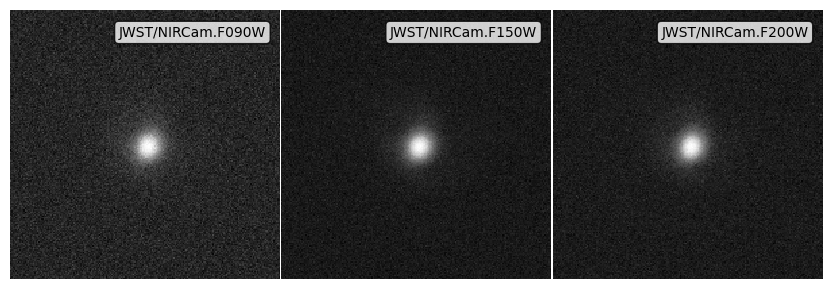

In [8]:
img_start = time.time()

# Get a noise array for each filter
noises = {
    f: np.random.normal(loc=0, scale=10**26.0, size=(psf_imgs.npix))
    * erg
    / s
    / Hz
    for f in psf_imgs.keys()
}

# Apply the noise array
noise_array_imgs = psf_imgs.apply_noise_arrays(noises)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_array_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from standard deviations

Noisy images made, took: 0.004899263381958008


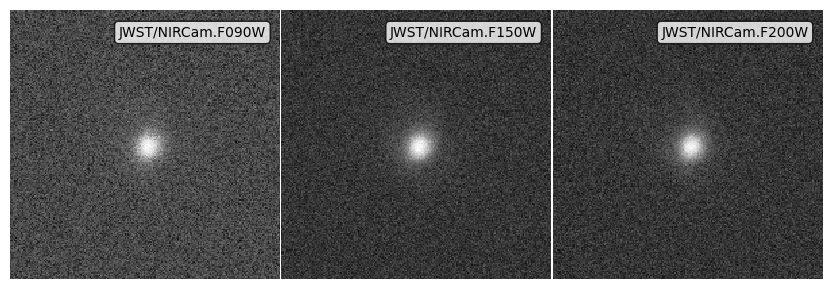

In [9]:
img_start = time.time()

# Get a noise standard deviation for each filter
noise_stds = {f: 10**26.3 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_std_imgs = psf_imgs.apply_noise_from_stds(noise_stds)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_std_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from an aperture depth

Noisy images made, took: 0.12467336654663086


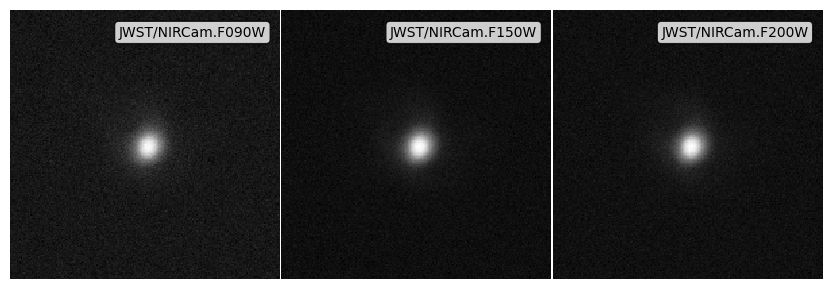

In [10]:
# Get dictionaries with the noise properties for each filter
snrs = {f: 5 for f in psf_imgs.keys()}
depths = {f: 10**28.0 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_app_imgs = psf_imgs.apply_noise_from_snrs(
    snrs=snrs, depths=depths, aperture_radius=0.5 * kpc
)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_app_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

### Noise from point source depth

Noisy images made, took: 0.24140644073486328


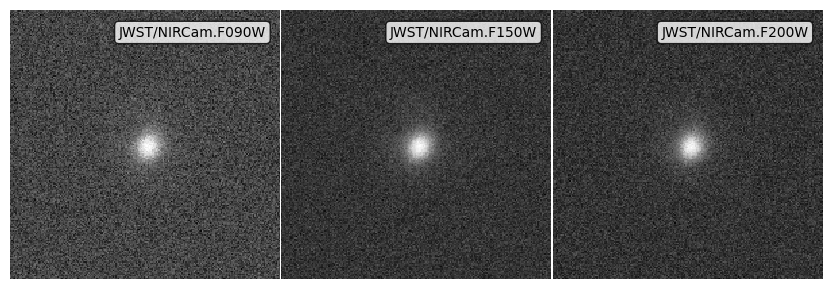

In [11]:
# Get dictionaries with the noise properties for each filter
snrs = {f: 5 for f in psf_imgs.keys()}
depths = {f: 10**27.0 * erg / s / Hz for f in psf_imgs.keys()}

# Apply the noise array
noise_ps_imgs = psf_imgs.apply_noise_from_snrs(snrs=snrs, depths=depths)

print("Noisy images made, took:", time.time() - img_start)

# Get the plot
fig, ax = noise_ps_imgs.plot_images(show=True, vmin=0, vmax=vmax)
plt.close(fig)

## Making an RGB image

Finally we can use the RGB image method on the `ImageCollection` to make quick RGB images by simply providing a dictionary detailing which filters we want in which bands, and optional weights for each filter (which we will ignore here).

Scaling to: 7.582874283696859e+25 -> 3.048882788642872e+27
(200, 200, 3)


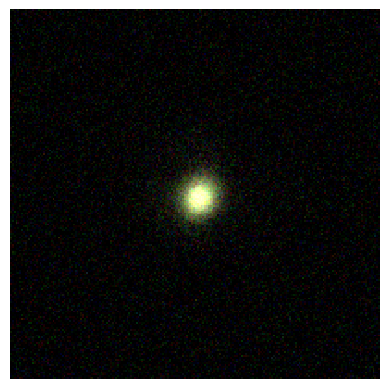

In [12]:
# Create the rgb image from the psf image above example using our 3 filters
rgb_img = noise_ps_imgs.make_rgb_image(
    rgb_filters={
        "R": [
            "JWST/NIRCam.F200W",
        ],
        "G": [
            "JWST/NIRCam.F150W",
        ],
        "B": [
            "JWST/NIRCam.F090W",
        ],
    },
)

# Set up minima and maxima
vmin = -np.percentile(rgb_img, 32)
vmax = np.percentile(rgb_img, 99.9)
norm = cm.Normalize(vmin=vmin, vmax=vmax, clip=True)
print("Scaling to:", vmin, "->", vmax)

# Normalise the image.
rgb_img = norm(rgb_img)

print(rgb_img.shape)

# Plot the image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(rgb_img, origin="lower", interpolation="nearest")
ax.axis("off")
plt.show()
plt.close(fig)